<a href="https://colab.research.google.com/github/eitanfass/image-processing/blob/main/image_processing_webapp_Eitan_Fass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

#@title Connect to Google drive run this cell olnly if you want to save results
from google.colab import drive

drive.mount('/content/drive') #import the Drive
save_to_path='/content/drive/MyDrive' #@param {type:"string"}
#@markdown This folder is where yoiur images will be saved

Mounted at /content/drive


In [4]:


#@title UPLOAD IMAGES HERE: RUN ME.  { display-mode: "form" }
 
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import io, img_as_ubyte
import numpy as np
from matplotlib import pyplot as plt
import cv2
import skimage.io as io
from google.colab import files
import shutil 
from scipy import ndimage
import os
import skimage.color
from skimage import img_as_float
from skimage import filters
import imutils
def createDir(path):
  doesExist = os.path.exists(path) # checks whether the specified path exists
  if not doesExist:
    os.makedirs(path) # create path, since it doesn't exist

try:
  uploaded = files.upload()
except:
  print("")
  print("Please use Chrome, and enable cookies!")
  print("cookie אנא היכנסו דרך דפדפן כרום במחשב, והפעילו גישה לקבצי ")

# lets the user upload the file, and stores the file name in 'file_names'. The files are uploaded under /content/FILE_NAME
file_names = list(uploaded.keys()) 


old_path=[f'/content/{i}' for i in file_names]

# Source path 
source = old_path[0]

# Destination path 
destination = f'{save_to_path}/uploads'#creat a new folder uploads in drive or use an existing folder
createDir(destination)
# Move the content of 
# source to destination 
dest = shutil.move(source, destination) #dest contains the path to the new image sfter moving to a speciphic folder



image = io.imread(dest)

Saving 282203124_5833336570044927_8522989190180500606_n.jpg to 282203124_5833336570044927_8522989190180500606_n (1).jpg


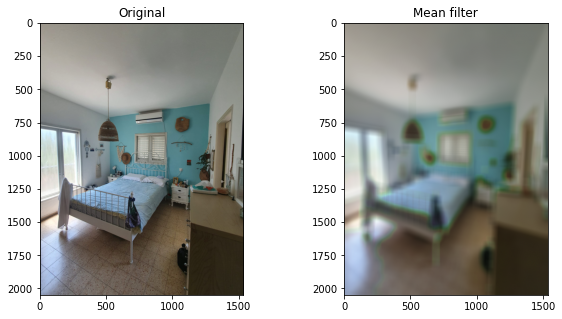

In [5]:
#@title Choose filter and set filter parameters.  { run: "auto" }

#@title


def imshow_all(images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax, cmap = 'gray')
        ax.set_title(label)

def mean_filter(image:np.ndarray,kernel_size:int=9, gray=True):
  if gray==True:
    image = skimage.color.rgb2gray(image)#convert to gray scale
    new_image = cv2.blur(image,(kernel_size, kernel_size))#run filter
    imshow_all([image,new_image],['Original','Mean filter'])#display
  else:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) # convert to HSV
    new_image = cv2.blur(image,(kernel_size, kernel_size))
    imshow_all([cv2.cvtColor(image, cv2.COLOR_HSV2RGB),cv2.cvtColor(new_image, cv2.COLOR_HSV2RGB)]
    ,['Original','Mean filter'])#display
  plt.show()
  return new_image



# The Gaussian filter returns a float image, regardless of input.
# Cast to float so the images have comparable intensity ranges.

def gaussian_filter(image,sigma=5,display=True):# returns a float image
  image_float = img_as_float(image)
  new_image = filters.gaussian(image_float, sigma=sigma)
  if display==True:
    plt.figure(figsize=(11,6))
    imshow_all([image,new_image],['Original','Gaussian Filter'])#display

  return normelize_0_1(new_image)
def normelize_0_1(img):
  return (img-img.min())/(img.max()-img.min())
  
def unsharp(image,sigma=10,sharp=0.15,display=True):
  gaussian_img=gaussian_filter(image,sigma,False)
  unsharp_image=gaussian_img
  for i in range(3):
    unsharp_image[:,:,i] = image[:,:,i] + ((image[:,:,i] - gaussian_img[:,:,i])*(1+sharp))
  if display==True:
    imshow_all([image,unsharp_image],['Original','Gaussian Filter'])#display

  return normelize_0_1(unsharp_image)


def watershed_func(img,distence_local_max=18):
  distence_local_max=20
  image=img.copy()
  shifted=gaussian_filter(image,1,False)
  shifted = cv2.pyrMeanShiftFiltering((shifted*255).astype('uint8'), image.shape[0]/10, image.shape[0]/10) # mean shift filtering to aid the thresholding step. only for rgb. read more here: https://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#pyrmeanshiftfiltering
  gray = cv2.cvtColor(shifted, cv2.COLOR_RGB2GRAY) # color to gray
  # thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
              cv2.THRESH_BINARY_INV,11,2)
  # Now let us visualize the output result
  fill_holes = ndimage.binary_fill_holes(thresh)
  # compute the exact Euclidean distance from every binary
  # pixel to the nearest zero pixel, then find peaks in this
  # distance map
  D = ndimage.distance_transform_edt(fill_holes)
  # Now we take D , our distance map, and find peaks (i.e., local maxima) in the map. We’ll ensure that is at least a 20 pixel distance between each peak.
  localMax = peak_local_max(D, indices=False, min_distance=distence_local_max,
    labels=fill_holes)
  # perform a connected component analysis on the local peaks,
  # using 8-connectivity, then appy the Watershed algorithm
  markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
  labels = watershed(-D, markers, mask=fill_holes) #  matrix of labels
  print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
  # loop over the unique labels returned by the Watershed algorithm
  total_area = [] # list to store areas of onjects
  for i,label in enumerate(np.unique(labels)):

    # if the label is zero, we are examining the 'background'
    # so simply ignore it
    if label == 0:
      continue
    # otherwise, allocate memory for the label region, and set the pixels belonging to the current label to 255 (white). draw it on the mask.
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255
    # detect contours in the mask and grab the largest one — this contour will represent the outline/boundary of a given object in the image.
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
      cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # calc area and append to list
    area = cv2.contourArea(c)
    total_area.append(area)
    print(f'Object number {i} has an area = ', area)

    ((x, y), r) = cv2.minEnclosingCircle(c)  # We find the circumcircle of an object using the function cv.minEnclosingCircle(). It is a circle which completely covers the object with minimum area.
    cv2.putText(image, "{}".format(label), (int(x) - 15 , int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2) # draw the ID on the object
    cv2.drawContours(image, cnts, -1, (0,255,0), 1) # draw the counters
  imshow_all([img,image],['Original','watershed segmentation Filter'])#display

    # return image,labels,fill_holes #fill_holes is the updated mask

  return image,labels,fill_holes #fill_holes is the updated mask

def k_means(image,K=4):
  # Convert MxNx3 image into Kx3 where K=MxN
  pixel_values  = image.reshape((-1,3))  #-1 reshape means, in this case MxN
  original_img=image.copy()
  #We convert the unit8 values to float as it is a requirement of the k-means method of OpenCV
  pixel_values = np.float32(pixel_values)
  # define stopping criteria
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
  # number of clusters (K)
  attempts = 10
  _, labels, (centers) = cv2.kmeans(pixel_values, K, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)
  # convert back to 8 bit values
  centers = np.uint8(centers)

  # flatten the labels array
  labels = labels.flatten()

  # convert all pixels to the color of the centroids
  segmented_image = centers[labels.flatten()]

  segmented_image = segmented_image.reshape(image.shape)
  # show the image

  mask_saver=[]
  for i in range(0,len(centers)):

    masked_image = image.copy()
    # convert to the shape of a vector of pixel values (like suits for kmeans)
    masked_image = masked_image.reshape((-1, 3))


    # color (i.e cluster) to exclude
    list_of_cluster_numbers_to_exclude = list(range(K)) # create a list that has the number from 0 to k-1
    list_of_cluster_numbers_to_exclude.remove(i) # remove the cluster that we want to keep, and not black out
    for cluster in list_of_cluster_numbers_to_exclude:
      masked_image[labels== cluster] = [0, 0, 0] # black all clusters except cluster 3

    # convert back to original shape
    masked_image = masked_image.reshape(image.shape)
    mask_saver.append(masked_image)
    # show the image
    
    # detect contours in an image and grab the largest one — this contour will represent the outline/boundary of a given object in the image.
    gray = cv2.cvtColor(masked_image, cv2.COLOR_RGB2GRAY) # color to gray
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1] # threshold the gray
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # find the boundaries 
    cnts = imutils.grab_contours(cnts) 
    c = max(cnts, key=cv2.contourArea)

    # # draw the contours enclosing the object
    cv2.drawContours(image, cnts, -1, (0,255,0), 1) # draw the counters

    # calc number of pixels within the object and append to list
    area = cv2.contourArea(c)
  
    imshow_all([image,masked_image],['Original with contours',f'cluster group {i+1} with center of {centers[i]} \n Object has an area = {area}pixels '])#display

  return mask_saver,segmented_image
Filter = "mean" #@param ["gaussien", "unsharp", "mean","grayscale mean"]
#@markdown gaussien and unsharp
sigma=7#@param  {type:"slider", min:1, max:50, step:1}
#@markdown unsharp
sharpness=0.31#@param {type:"slider", min:0.01, max:0.5, step:0.05}
#@markdown mean filters
kernel_size=58#@param {type:"slider", min:3, max:100, step:1}

save_image = False #@param {type:"boolean"}

if Filter=="gaussien":
  
  new_image=gaussian_filter(image,sigma)
elif Filter=="unsharp":
  new_image=unsharp(image,sigma,sharpness)

elif Filter=="grayscale mean":
  new_image=mean_filter(image,kernel_size)
elif Filter=="mean":
  new_image=mean_filter(image,kernel_size,False)
if save_image == True:
  createDir(save_to_path)
  io.imsave(fname = f'{save_to_path}/{Filter}_{file_names[0]}', arr=np.ndarray(new_image)) #save img

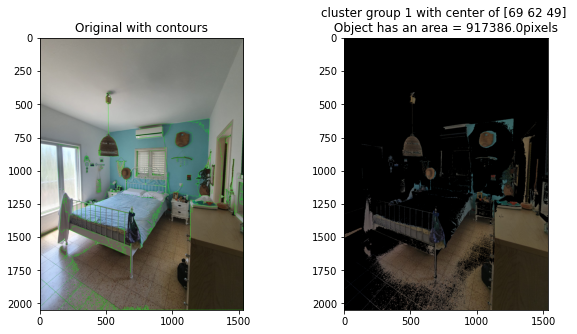

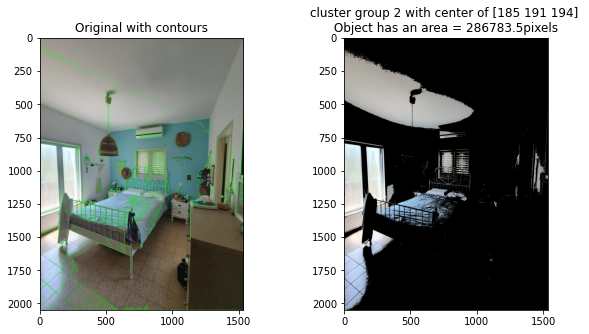

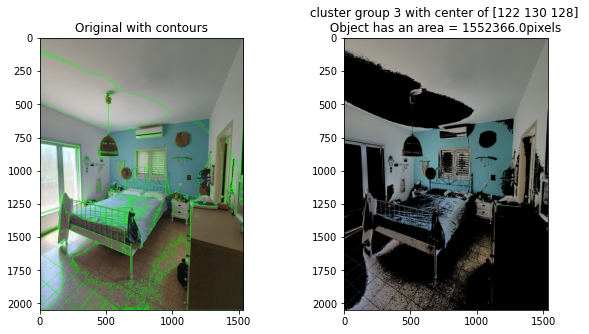

In [6]:
#@title Choose segmentetion method and set its parameters:  { run: "auto" }
#@markdown runing segmentation may take some time...
segmentation_method = "K-means" #@param ["watershed", "K-means"]
K=3#@param {type:"slider", min:2, max:10, step:1}
distence_2_local_max=23#@param {type:"slider", min:1, max:60, step:1}
save_image = False #@param {type:"boolean"}
if segmentation_method=="watershed":
  new_image, labels, mask=watershed_func(image,distence_2_local_max)
  if save_image == True:
    createDir(save_to_path)
    io.imsave(fname = f'{save_to_path}/{segmentation_method}_{file_names[0]}', arr=new_image) #save img
if segmentation_method=="K-means":
  mask_saver,segmented_image=k_means(image,K)
  if save_image == True:
    createDir(save_to_path)
    for i,mask in enumerate(mask_saver):
      io.imsave(fname = f'{save_to_path}/{segmentation_method}_k{i}_{file_names[0]}', arr=np.ndarray(mask)) #save img